# Семинар по фреймворку для глубокого обучения - PyTorch

## pytorch = numpy + CUDA + autograd

## Основы PyTorch

In [6]:
import torch
import numpy as np

# можно создавать тензоры из списков чисел, как и numpy-массивы
t = torch.Tensor([0, 0, 0])
t

tensor([0., 0., 0.])

In [7]:
# размерность тензора
t.shape

torch.Size([3])

In [8]:
b = torch.Tensor([1, -1, 2])
# арифметические операции
print(t + b)
print(t - b)
print(t * b)
print(t / b)

tensor([ 1., -1.,  2.])
tensor([-1.,  1., -2.])
tensor([0., -0., 0.])
tensor([0., -0., 0.])


In [9]:
# torch.view() - аналог np.reshape(), меняет размерности тензора
print(t.view(1, 3))
print(t.view(3, 1))

tensor([[0., 0., 0.]])
tensor([[0.],
        [0.],
        [0.]])


Для того, чтобы подключить к серверу видеокарточку, нужно в меню 'Runtime' выбрать пункт 'Change runtime type', а в появившемся окне в поле 'Hardware accelerator' выбрать 'GPU' (и, естественно, нажать 'Save'). После этого выполните ячейку ниже - в выводе должна быть табличка с системной информацией о доступной видеокарте.

In [10]:
# как и в обычном jupyter-блокноте, в colab можно вызывать команды операционной системы через восклицательный знак
# команда nvidia-smi показывает служебную информацию о видеокартах NIVIDA в системе
!nvidia-smi

Sat Dec  3 10:36:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Основной объект, с которым pytorch проводит вычисления - это *тензор*. В данном случае тензор - это просто многомерный массив с числами, а не математическое понятие тензора. Работать с тензорами можно практически также, как и с массивами numpy:

Для начала, реализуем с помощью pytorch те же сети - однослойную и двухслойную, которые написали в прошлый раз на numpy, обучая их на том же датасете - CIFAR-10

## Нейронные сети на PyTorch

PyTorch предоставляет много готовых "блоков" для создания нейросетей - готовых слоев, которые можно соединять друг с другом, причем все "магия" (функции ошибки, дифференцирование, обновление весов и т.д.) будет делаться практически автоматически - нужно лишь указать, что считать, а как pytorh знает сам :). Для того, чтобы написать свою нейронную сеть на pytorch, нужно сделать три вещи: создать класс, наследующийся от torch.nn.Module; внутри него описать слои, из которых состоит сеть, а потом определить метод forward(), в котором описать прямой проход по сети - ровно так же, как мы это делали на numpy (а на самом деле, и еще проще):

In [11]:
import torch.nn as nn  # вещи, связанные с нейронными сетями лежат внутри модуля torch.nn


class OneLayerNet(nn.Module):  # создадим однослойный перцептрон
  
    def __init__(self, in_d, out_d):
        super().__init__()  # при наследовании в python необходимо вызвать конструктор класса-родителя

        # здесь нужно описать слои, из которых состоит наша сеть
        # сейчас мы хотим реализовать однослойный перцептрон, поэтому нам нужен всего один линейный (полносвязный) слой:
        self.linear1 = nn.Linear(in_features=in_d, out_features=out_d)

    def forward(self, x):
        # здесь нужно описать последовательность вычислений при прямом проходе сети - когда мы даем сети на вход данные и хотим получить ответы на выходе
        # x в данном случае - входной тензор размерности (batch x in_d), содержащий данные
        out = self.linear1(x)  # все слои в PyTorch можно применять к данным как функции
        return out

Все! На этом код, описывающий однослойную модель закончен. Осталось написать загрузку и предобработку данных, а также цикл обучения сети:

In [12]:
# загрузка данных очень проста, потому что большинство популярных датасетов уже встроены в PyTorch
# в пакете torchvision содержится много полезного для работы с изображениями
from torchvision import datasets
# трансформации изображений для правильной предобработки
import torchvision.transforms as transforms

# датасеты внешне выглядят как списки - по индексу они возвращают изображение в формате Pillow.imread() и соответствующую ему метку класса
# однако, PyTorch проводит вычисления с тензорами, поэтому
# 1) нам нужно превратить изображения в тензора torch
# 2) в Pillow-изображениях все пиксели уже нормированны на [0, 1], поэтому нам остается просто вычесть по 0.5 из каждого канала изображения и поделить на 0.5, что приведет значения всех пикселей в отрезок [-1, 1]
# 3) вытянуть тензор в строчку, потому что мы работаем сейчас с полносвязными сетями, которые ждут на вход вектор, а не матрицу
# нормирование пикселей в [-1, 1] нужно потому что такими входными данными нейросетям работать легче.

# с помощью Compose можно объединить две или более трансформаций в одну
transform = transforms.Compose([
    transforms.ToTensor(),  # превращаем изображение в тензор для pytorch
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x.flatten()),  # и вытягиваем тензор в строчку
])
# теперь можно загрузить обучающую и тестовую выборки, сами изображения скачаются из Интернета
trainset = datasets.CIFAR10(root='.', download=True, transform=transform)
testset = datasets.CIFAR10(root='.', train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


In [13]:
# сводная информация по train & test датасетам
print(trainset)
print(testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Lambda()
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Lambda()
           )


In [14]:
trainset[0]  # посмотрим на первый объект из трейн датасета

(tensor([-0.5373, -0.6627, -0.6078,  ...,  0.0980, -0.3412, -0.4353]), 6)

In [17]:
from torch.utils.data import DataLoader

# следующее, что нам понадобится - это два объекта класса dataloader: эти штуки будут забирать пакет примеров из датасета и прогонять его через сеть, поскольку мы будет пользоваться пакетным градиентным спуском
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(testset, batch_size=128)
# для обучения сети лучше подавать батчи (пакеты) в случайном порядке, во время теста же это не имеет значения (shuffle=True)
# batch_size, соответственно, это размер пакета, в данном примере - 128

In [18]:
# еще нам нужна функция ошибки, которую мы будем минимизировать градиентным спуском
# поскольку мы решаем задачу многоклассовой классификации, то в качестве функции ошибки будет использовать кросс-энтропию (это стандартная для задач классификации функция ошибки)
criterion = nn.CrossEntropyLoss()  # в PyTorch есть готовый объект

Сначала перепишем на PyTorch функцию `eval_model`:

In [19]:
from tqdm.auto import tqdm  # импортируем tqdm для удобных прогресс-баров
from sklearn.metrics import classification_report


def eval_model(model, dataloader, criterion, classes):  # функция применения сети к датасету и подсчета метрик
    predictions, ground_truth = [], []  # контейнеры для предсказаний сети и правильных меток
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Evaluation', leave=False):
            # конвертация из тензоров в матрицы numpy
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)  # предсказания модели (но не вероятности)
            # расчет функции ошибки (кросс-энтропии)
            val_loss += criterion(outputs, labels).item()  # .item() превращает тензор размерности [1] в простое число (скаляр)

            y_pred = outputs.argmax(dim=1).cpu().numpy()
            predictions.append(y_pred)
            ground_truth.append(labels.cpu().numpy())
    val_loss /= len(dataloader)
    predictions = np.concatenate(predictions)
    ground_truth = np.concatenate(ground_truth)
    # предсказанные метки используем для расчета классификационных метрик
    report = classification_report(ground_truth, predictions, target_names=classes, zero_division=0)
    return val_loss, report

Теперь перепишем функцию обучения сети `train_model`:

In [20]:
def train_model(model, train_loader, val_loader, criterion, epochs, lr, classes):
    history = {'train_loss': [], 'val_loss': []}  # словарь, в который будем складывать метрики чтобы потом нарисовать графики
    # нам нужен объект, который будет менять веса сети
    # объекты, которые меняют веса, и, по факту, реализуют градиентный спуск, в PyTorch называются оптимизаторами (optimizer)
    # но по сути, внутри него те же самые формулы, которые мы реализовывали на numpy, и которые вы видели в презентации
    # в оптимизатор нужно передать параметры, которые он будет менять в нужную сторону
    # для этого можно вызвать у объекта net метод parameters() и получить ссылку на все обучаемые параметры в сети - это торч тоже делает автоматически
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # первый цикл - по количеству эпох
    # эпохой называется одна итерация, во время которой сеть пропускает через себя все уникальные примеры в датасете
    # обычно сети не достаточно по одному разу увидеть обучающие примеры, поэтому проходов по всем данным делают несколько
    with tqdm(total=epochs, desc='Epoch') as epoch_pbar:  # цикл по эпохам
        for _ in range(epochs):
            running_loss = 0  # счетчик текущего значения функции ошибки
            # теперь запускаем цикл по пакетам данных
            # даталоадер в случайном порядке (но без повторений) будет возвращать по batch_size примеров, пока данные не закончатся
            with tqdm(total=len(train_loader), desc='Batch', leave=False) as batch_pbar:  # создаем прогресс-бар по батчам
                # цикл по батчам, enumerate кроме самого пакета с данными возвращает и его номер (последовательный)
                for idx, (images, labels) in enumerate(train_loader, start=1):
                    images = images.cuda()
                    labels = labels.cuda()

                    optimizer.zero_grad()  # сначала нужно обнулить производные оптимизатора - это особенность PyTorch
                    outputs = model(images)  # теперь делаем прямой проход сети и получаем текущие ответы сети
                    loss = criterion(outputs, labels)  # считаем, насколько сеть неправа (функция ошибки)

                    # говорим сети, какие параметры неправы, и в какую сторону их нужно двигать, чтобы быть лучше (считаем производные)
                    loss.backward() # всего одна строчка! и никакого матана
                    optimizer.step()  # и двигаем параметры в нужную сторону

                    running_loss += loss.item()  # для вывода статистики
                    # обновим вложенный прогресс-бар
                    batch_pbar.set_postfix(loss=running_loss / idx)
                    batch_pbar.update()

            running_loss /= len(train_loader)
            # получим метрики на валидации для этой эпохи
            val_loss, _ = eval_model(model, test_loader, criterion, classes)
            history['train_loss'].append(running_loss)
            history['val_loss'].append(val_loss)
            # обновим прогресс-бар эпох
            epoch_pbar.set_postfix(loss=running_loss, val_loss=val_loss)
            epoch_pbar.update()
    return history

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_metrics(history):
    fig, ax = plt.subplots(figsize=(14, 8))
    n_epochs = len(history['train_loss'])
    ax.plot(range(n_epochs), history['train_loss'], label='train_loss')
    ax.plot(range(n_epochs), history['val_loss'], label='val_loss')
    ax.set_title('Loss')
    ax.set_xlabel('Epoch')
    ax.legend()
    plt.show()

Теперь создаем экземпляр нашей сети, отправляем ее на видеокарту и запускам обучение. Например, на 10 эпох с шагом обучения 1e-4

In [22]:
# размерность входных данных input_dim = 32 * 32 * 3 = 3072, выходных out_dim = 10 (количество классов)
model = OneLayerNet(in_d=32 * 32 * 3, out_d=10).cuda()  # вызов .cuda() отправляет нашу сеть на видеокарту
history = train_model(model, train_loader, test_loader, criterion, epochs=20, lr=1e-4, classes=trainset.classes)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Batch:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

Построим график, показывающий как уменьшалась функция ошибки по мере обучения:

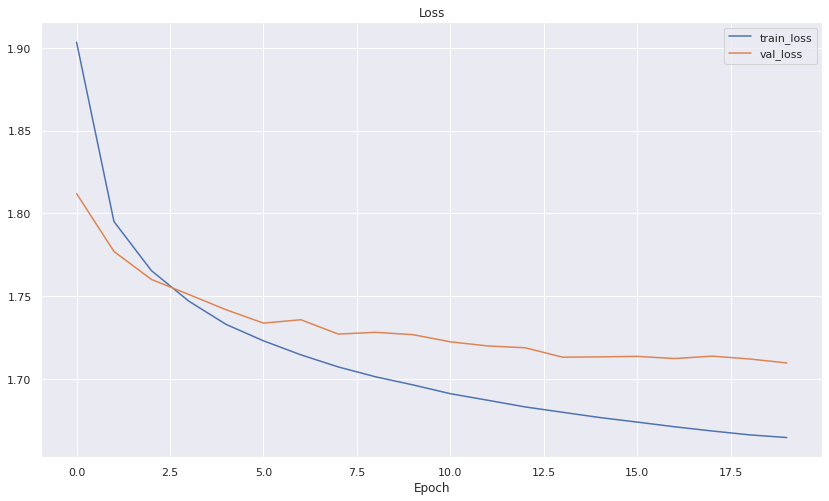

In [23]:
plot_metrics(history)  # график метрик

In [24]:
# метрики на трейне
_, train_report = eval_model(model, train_loader, criterion, classes=trainset.classes)
print(train_report)

Evaluation:   0%|          | 0/391 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    airplane       0.50      0.47      0.49      5000
  automobile       0.47      0.53      0.50      5000
        bird       0.37      0.29      0.32      5000
         cat       0.34      0.28      0.31      5000
        deer       0.40      0.38      0.39      5000
         dog       0.41      0.33      0.37      5000
        frog       0.42      0.55      0.47      5000
       horse       0.50      0.47      0.48      5000
        ship       0.52      0.56      0.54      5000
       truck       0.45      0.54      0.49      5000

    accuracy                           0.44     50000
   macro avg       0.44      0.44      0.44     50000
weighted avg       0.44      0.44      0.44     50000



In [25]:
# метрики на тесте
_, val_report = eval_model(model, test_loader, criterion, classes=trainset.classes)
print(val_report)

Evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    airplane       0.47      0.45      0.46      1000
  automobile       0.46      0.51      0.48      1000
        bird       0.33      0.27      0.30      1000
         cat       0.30      0.25      0.27      1000
        deer       0.37      0.34      0.35      1000
         dog       0.37      0.31      0.34      1000
        frog       0.40      0.53      0.46      1000
       horse       0.47      0.46      0.47      1000
        ship       0.49      0.54      0.51      1000
       truck       0.42      0.50      0.46      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.41     10000
weighted avg       0.41      0.41      0.41     10000



In [ ]:
# функция визуализации выученных весов нейронной сети для каждого класса
def visualize_weights(weights_matrix, classes):
    weights_matrix = weights_matrix.copy()  # превратим веса относительно каждого класса в набор картинок 32x32x3
    weights_matrix = weights_matrix.reshape(3, 32, 32, 10)
    weights_matrix = np.moveaxis(weights_matrix, 0, -2)  # переставим каналы в правильном порядке
    w_min, w_max = weights_matrix.min(), weights_matrix.max()  # для нормировки узнаем минимальный и максимальный веса

    fig, axes = plt.subplots(2, 5, figsize=(16, 8))
    axes = [ax for ax_row in axes for ax in ax_row]
    for idx, ax in enumerate(axes):
        w_img = 255 * (weights_matrix[:, :, :, idx].squeeze() - w_min) / (w_max - w_min)  # отмасштабируем веса в отрезок [0, 255]
        w_img = w_img.astype('uint8')
        
        ax.imshow(w_img)
        ax.grid(False)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_title(classes[idx])
    plt.show()

In [ ]:
visualize_weights(model.linear1.weight.cpu().detach().numpy().T, trainset.classes)

## Двухслойная сеть

Теперь построим двухслойную сеть точно так же, как и однослойную:

In [26]:
class TwoLayerNet(nn.Module):

    def __init__(self, in_d, hidden_d, out_d):
        super().__init__()
        # размерности должны быть согласованы между слоями (hidden_d)
        self.linear1 = nn.Linear(in_features=in_d, out_features=hidden_d)
        self.relu = nn.ReLU()  # в качестве промежуточной функции активации будем использовать ReLU:
        self.linear2 = nn.Linear(in_features=hidden_d, out_features=out_d)
        
    def forward(self, x): 
        h = self.relu(self.linear1(x))  # применяем ReLU к выходам первого слоя
        out = self.linear2(h)  # и отправляем во второй слой
        return out

Используем для обучения и проверки уже готовые функции:

In [37]:
train_loader = DataLoader(trainset, batch_size=1024, shuffle=True)
test_loader = DataLoader(testset, batch_size=1024)

model = TwoLayerNet(in_d=32 * 32 * 3, hidden_d=15, out_d=10).cuda()
history = train_model(model, train_loader, test_loader, criterion, epochs=25, lr=1e-4, classes=trainset.classes)

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/49 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

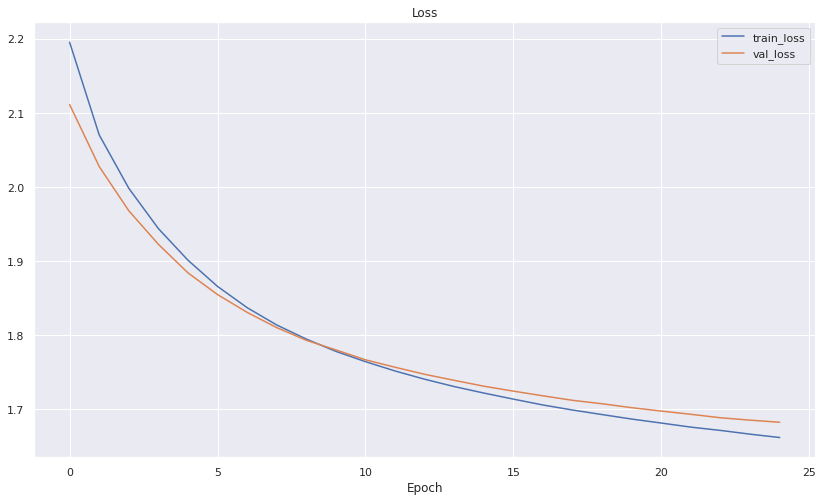

In [38]:
plot_metrics(history)  # график метрик

Функция ошибки уменьшилась сильнее, чем в случае с однослойной сетью - это значит, что сеть должна была обучиться лучше. Смотрим на качество на трейне и тесте:

In [39]:
# метрики на трейне
_, train_report = eval_model(model, train_loader, criterion, classes=trainset.classes)
print(train_report)

Evaluation:   0%|          | 0/49 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    airplane       0.49      0.48      0.49      5000
  automobile       0.46      0.56      0.50      5000
        bird       0.35      0.27      0.30      5000
         cat       0.31      0.23      0.27      5000
        deer       0.44      0.28      0.34      5000
         dog       0.37      0.36      0.37      5000
        frog       0.40      0.50      0.45      5000
       horse       0.41      0.49      0.44      5000
        ship       0.54      0.59      0.56      5000
       truck       0.45      0.52      0.48      5000

    accuracy                           0.43     50000
   macro avg       0.42      0.43      0.42     50000
weighted avg       0.42      0.43      0.42     50000



In [40]:
# метрики на тесте
_, val_report = eval_model(model, test_loader, criterion, classes=trainset.classes)
print(val_report)

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

              precision    recall  f1-score   support

    airplane       0.48      0.49      0.49      1000
  automobile       0.46      0.55      0.50      1000
        bird       0.30      0.24      0.27      1000
         cat       0.28      0.21      0.24      1000
        deer       0.44      0.26      0.32      1000
         dog       0.38      0.37      0.37      1000
        frog       0.40      0.51      0.45      1000
       horse       0.38      0.47      0.42      1000
        ship       0.51      0.57      0.54      1000
       truck       0.42      0.47      0.45      1000

    accuracy                           0.41     10000
   macro avg       0.41      0.41      0.40     10000
weighted avg       0.41      0.41      0.40     10000



**ЗАДАНИЕ:** посмотрите влияние параметров на процесс обучения и качество двухслойной сети. Попробуйте подобрать такие параметры (batch_size, hidden_dim. learning_rate) чтобы получить лучшее качество на тесте.


---



**ЗАДАНИЕ:** основываясь на примерах выше, напишите **трехслойную** (или еще более глубокую, если хотите, тут вы ограничены только вычислительными ресурсами Colab) сеть, и подберите такие параметры, чтобы получить максимальную долю правильных ответов (accuracy) на **тесте**.